# Предсказываем погоду
## Цель: написать приложение для прогнозирования погоды
### От приложения требовалось:
    1)предсказание характера погоды на завтра: 'облачно', 'дождь' и т.п.
    
    2)определение температуры
    
    3)предсказание на основе подходов из машинного обучения
    
## Основные этапы:
    1)Разработка и поиск моделей для п.1)-2)
    
    2)Сбор и обработка данных
    
    3)Выбор способа реализации и реализация
    
    4)Поиск подходящих моделей в машинном обучении и временных рядах
    
### Разработка и поиск моделей для п.1)
   Задача предсказания характера погоды является одним из классических примеров использования марковских
    цепей. Рассмотрим следующую модель, которая и была взята в качестве основной.
    
   Пусть имеется вектор распределения вероятностей в начальный момент времени $p^0 = (p^0_1, p^0_2, p^0_3)$, где компоненты выражают следующие вероятности: (ясно, облачно, дождь). Например, в солнечный, ясный день вектор будет выглядеть следующим образом: $p^0 = (1, 0, 0)$.
   
   Определим также переходную матрицу:
   $\begin{equation*}
    T =
    \begin{pmatrix}
    0.5 & 0.3 & 0.2\\
    0.25 & 0.5 & 0.25\\
    0.2 & 0.4 & 0.4\\
    \end{pmatrix}
    \end{equation*}$
    
   Таким образом, мы можем получить прогноз погоды на следующий день: $(0.5, 0.3, 0.2)$.
   
   То есть для прогноза погоды на завтра нам необходимо обладать переходной матрицей и вектором распределения вероятностей.
   
   ### Откуда взять матрицу?
   
   #### Идея:
   для определения элементов матрицы воспользуемся следующим рассуждением:
   
   поскольку для вычисления
       элемента $i,j$ матрицы нам нужно знать вероятность перехода из состояния $i$ в состоояние $j$, то в пределах
       месяца рассмотрим все дни, характеризовавшиеся $i$-ым состоянием(пусть таких дней $n$), запомним индексы этих дней:
       $[d_k, d_p, ...]$, а затем рассмотрим следующие дни, соответственно с индексами $[d_{k+1}, d_{p+1}]$ и рассмотрим каким состояниями характеризовались они, подсчитаем среди них число дней с состоянием $j$(пусть таких дней $k$), что и позволит нам вычислить необходимую вероятность $p_{ij} = \frac{k}{n}$.
       
### Сбор и обработка данных

   Для построения точного прогноза необходимо учитывать сезонность: матрицы хотелось строить для каждого отдельного месяца, что порождало свои трудности.
   
   Изначально была попытка воспользоваться данными с rp5.ru. Первые результаты работы конечного приложения были получены на этих данных. Однако данные были достаточно разреженными и несбалансироваными, требовалось много предварительной обработки.
   
   В конечном итоге данные были взяты с weatherOnline(сайт предоставляет 60 дней бесплатного пользования их API) - погода за последние 10 лет в Москве.
   
   Для получения более точного прогноза имело смысл рассмотреть начальный вектор и матрицу большей размерности, однако это также могло привести к тому, что данные будут очень несбалансированными, поэтому было введено только одно дополнительное состояние - снег, а многие уникальные состояния в данных были объединены.
   
    Пример характеристик, объединённых в состояние снег:
             'Light snow', 'Patchy moderate snow', 'Heavy freezing drizzle',
             'Moderate snow', 'Heavy snow', 'Light snow showers',
             'Moderate or heavy sleet', 'Moderate or heavy snow showers',
             'Light sleet', 'Light sleet showers', 'Patchy snow possible',
             'Blizzard', 'Patchy heavy snow', 'Patchy light snow'
     
   После обработки получались матрицы следующего вида:
$$\begin{equation*}
T =
\begin{pmatrix}
su\rightarrow su & su\rightarrow c  & su\rightarrow r & su\rightarrow sn\\
c\rightarrow su & c\rightarrow c & c\rightarrow r & c\rightarrow sn\\
r\rightarrow su & r\rightarrow c & r\rightarrow r & r\rightarrow sn\\
sn\rightarrow su & sn\rightarrow c & sn\rightarrow r & sn\rightarrow sn
\end{pmatrix}
\end{equation*}$$ 

### Выбор способа реализации и реализация
   В качестве основных вариантов реализации рассматривались сайт и телеграм-бот, выбор был сделан в пользу последнего, в силу того, что для определения погоды требовалось проводить вычисления(умножение вектора на матрицу:) ), что требовало реализации бэкэнда(пусть и простого).
   
   Для реализации просто телеграм-бота достаточно ознакомления со следующей статьей: https://habr.com/en/post/448310/.
   
#### Работа бота:
    Получив запрос на прогноз погоды, бот узнаёт текущие дату и время, формирует API запрос на получение
    погоды на текущий день, ответ содержит описание погоды с периодичностью 3 часа, исходя из этого
    формируется итоговый вектор, который домножается на матрицу, соответсвующую текущей дате. Полученный
    вектор интерпретируется по определенному правилу, что позволяет пользователю видеть привычный
    прогноз.
    
    Очевидным преимуществом такой реализации является автоматизированность.
    Однако weatherOnline предоставляет бесплатный доступ к своему API только на 60 дней,
    по истечении этого срока, автоматически узнавать погоду приведенным способом
    не получится, однако изначально приложение написано в другом формате: пользователь сам 
    выбирает текущую погоду из 12 вариантов, что позволяет получить вектор начального распределения,
    а следовательно и предсказать погоду, так что после окончания пробного периода можно вернуться 
    к старой версии.
    
### Температура

будем рассматривать следующий вектор: $t = (t_{<-5}, t_{[-5;-2]}, t_{[-2;2]}, t_{[2;5]}, t_{>5})$

$t_{<-5}$ - температура уменьшится более чем на 5 градусов,

$t_{[-5;-2]}$ - температура уменьшится на 2-5 градусов,

$t_{[-2;2]}$ - температура будет меняться в пределах от -2 до 2 градусов,

$t_{[2;5]}$ - температура увеличится на 2-5 градусов ,

$t_{>5}$ - температура увеличится более чем на 5 градусов
    
Матрица строится аналогичным образом. 




### Машинное обучение
Решающие деревья:

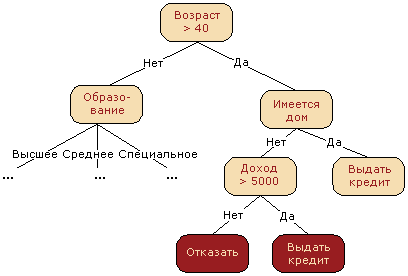

   В задаче регрессии в качестве ошибки часто используется 
   $$MSE(a,X) = \dfrac{a}{l}\sum_{i=1}^l(a(x_i) - y_i)^2$$
   
   Решающее дерево $a(x)$ разбивает все признаковое пространство на некоторое количество не пересекающихся подмножеств ${R_1, R_2, ... R_n}$. В каждом подмножестве $R_j$ выдаёт константный прогноз $b_j$, тогда решающее дерево выглядит так:
   $$b(x) = \sum_1^J [x \in R_j]b_j$$
   
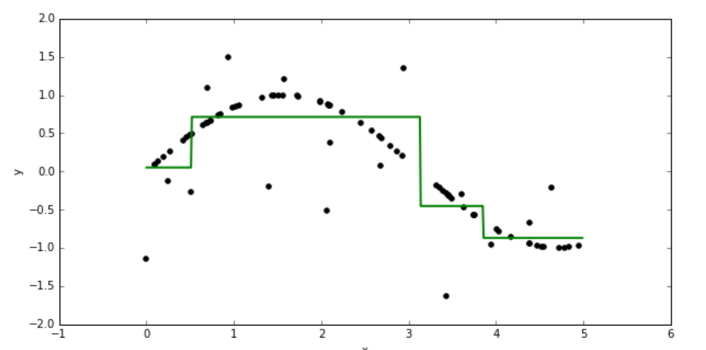

   В градиентном бустинге каждый новый базовый алгоритм $b_N$ прибавляется к уже построенной модели:
   $$a_N(x) = a_{N-1}(x) + b_{N}(x)$$
   Для решающих деревьев:
   $$a_N(x) = a_{N-1}(x) + \sum_{j=1}^J[x \in R_{Nj}]b_{Nj}$$
   Это выражение можно проинтерпретировать не только, как прибавление одного решающего дерева, но и как прибавление $J$ очень простых алгоритмов, каждый из которых возвращает постоянное значение на некоторой области и ноль на всем остальном простанстве.
   Новый алгоритм $b_N(x)$ обучается, чтобы как можно сильнее уменьшить ошибку композиции на обучающей выборке:
   $$\sum_{i=1}^{l}L(y_i, a_{N-1}(x_i) + b(x_i)) \rightarrow \min_b$$
   Сначала имеет смысл решить более простую задачу: определить, какие значения $s_1,...,s_l$ должен принимать алгоритм $b_N(x_i) = s_i$на объектах обучающей выборки, чтобы ошибка на обучающей выборке была минимальной:
   $$F(s) = \sum_{i=1}^l L(y_i, a_{N-1}(x_i) + s_i) \rightarrow \min_s$$
   
   $$s = - \nabla F$$
   
   $$b_N(x) = argmin_b \dfrac{1}{l} \sum_{i=1}^{l}(b(x_i) - s_i)^2$$
   
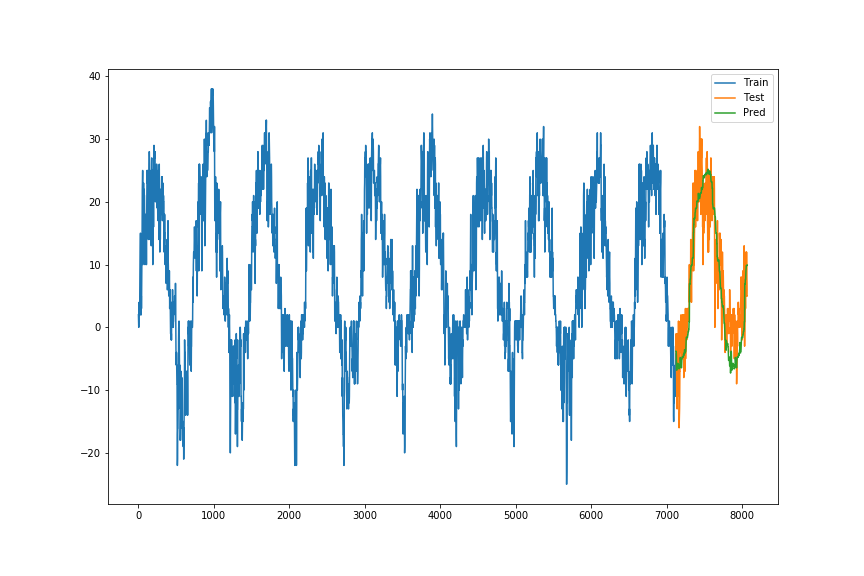

https://www.coursera.org/learn/supervised-learning/supplement/flyUL/konspiekt